In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 02/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = ''

In [3]:

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'



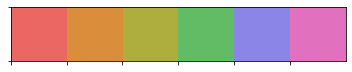

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [5]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [6]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

### Load formatted scores

In [7]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

### Calculate lights off and on in Zeitgeber time (s and hrs)

In [8]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [9]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## PlotFig

In [10]:
def PlotFig(b_num, plot_xlabels=True, plot_lightsonoff=True, full_stagelabels=False,
           sr=sr, colors=colors, 
           xlim_min= np.mean(lightsOffZeit_hr)-1, 
           stages=stages, AllScores=AllScores):
    '''Plot Figure: hypnogram
    b_num = bird number (starting at 0)
    plot_xlabels = whether to plot the time & label at the bottom
    plot_lightsonoff = whether to plot the text labeling the lights on & off lines
    
    sr = sampling rate
    colors = list of colors to use for plotting sleep stages
    xlim_min = where to start plotting, in hrs
    stages = list of sleep/wake stages
    AllScores = dictionary of scores for each bird
    
    '''
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name].copy()
    
    axis_color = [.8,.8,.8]
    
    xlim_max = xlim_min + 24
    if lightsOffZeit_hr[b_num]<xlim_min:
        lights_off = lightsOffZeit_hr[b_num] + 24
    else:
        lights_off = lightsOffZeit_hr[b_num]
                
    # for Zeitgeber times falling before the desired Xmin, wrap around to next day by adding 24hrs
    too_early_inds = np.where(Scores['Zeitgeber time (h)'] < xlim_min)
    new_Zeit_hrs = Scores['Zeitgeber time (h)'].iloc[too_early_inds].copy() + 24
    Scores['Zeitgeber time (h)'].iloc[too_early_inds] = new_Zeit_hrs.values
                           
    # for each stage, make a vlines plot
    with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline
        for st in range(len(stages)):
            stage_scores = Scores[Scores['Label (#)']==st]
            
            plt.vlines(stage_scores['Zeitgeber time (h)'], -st, -st - 1, 
                   color=colors[st], alpha=0.1,lw=1)
            
            plt.axhline(-st, color=axis_color, lw=1)   # gridlines
        
        # vertical lines at lights on and off
        plt.axvline(0, alpha=0.4, color='k', lw=3)
        plt.axvline(lights_off, alpha=0.4, color='k', lw=3)
        
        if plot_lightsonoff:
            plt.text(-.75, 0.3, 'lights on', alpha=0.7, fontsize=22)
            plt.text(lights_off - .75, 0.3, 'lights off', alpha=0.7, fontsize=22)

        # labels of each stage
        if full_stagelabels:
            stage_labels = ['Wake','Drowsy','Unihem','IS', 'SWS', 'REM']
        else:
            stage_labels = ['W','D','U','I','S','R']
        
        plt.yticks(-0.5 - np.arange(len(stages)), stage_labels, fontsize=22, fontweight='bold')
        
        ax = plt.gca()
        #ax.yaxis.tick_right()     # labels on right side of plot
        for ytick, color in zip(ax.get_yticklabels(), colors):   # text color
            ytick.set_color(color)

        # axis labels    
        plt.ylabel(b_name, fontsize=24)
        if plot_xlabels:
            plt.xlabel('Zeitgeber hour', fontsize=24)
            ticks = ax.get_xticks()
            plt.xticks(np.arange(xlim_min, np.max(ticks), 2))
        else:
            plt.xticks([])

        # limits
        plt.xlim(xlim_min, xlim_max)
        plt.ylim(-len(stages), 0)
        
        plt.tight_layout()


# FIGURE 2A: Plot just one hypnogram

In [28]:
AllScores['Bird 2']

,Video Label,Label,Label (#),Time (s),Time (h),Zeitgeber time (s),Zeitgeber time (h),Zeitgeber time (ep),Epoch #
2014-11-14 16:03:06,q,w,0,0,0.000000,-48168,-13.380000,-16056,0
2014-11-14 16:03:09,q,w,0,3,0.000833,-48165,-13.379167,-16055,1
2014-11-14 16:03:12,q,w,0,6,0.001667,-48162,-13.378333,-16054,2
2014-11-14 16:03:15,q,w,0,9,0.002500,-48159,-13.377500,-16053,3
2014-11-14 16:03:18,q,w,0,12,0.003333,-48156,-13.376667,-16052,4
...,...,...,...,...,...,...,...,...,...
2014-11-15 15:59:45,q,w,0,86199,23.944167,38031,10.564167,12677,28733
2014-11-15 15:59:48,q,w,0,86202,23.945000,38034,10.565000,12678,28734
2014-11-15 15:59:51,q,w,0,86205,23.945833,38037,10.565833,12679,28735
2014-11-15 15:59:54,q,w,0,86208,23.946667,38040,10.566667,12680,28736


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


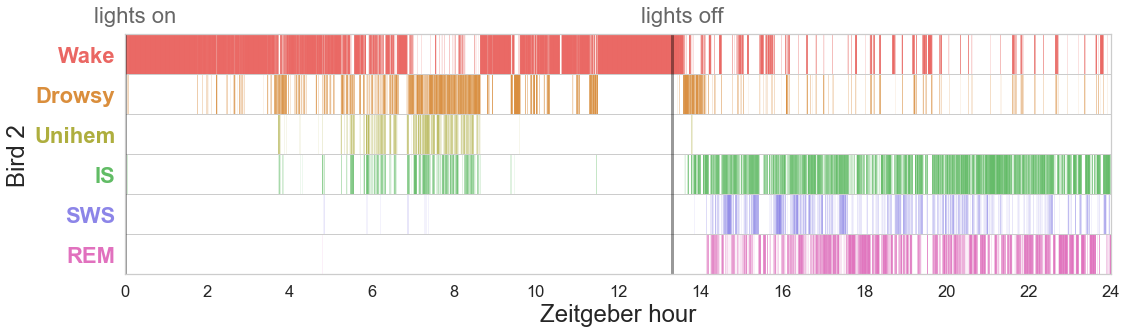

In [30]:
# Bird 2 
b = 1
b_name = 'Bird ' + str(b+1)
plt.figure(figsize=(16,5))

   
plot_lightsonoff = True
full_stagelabels = True
plot_xlabels = True
        
axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline    
    PlotFig(b, plot_xlabels=plot_xlabels,
            plot_lightsonoff=plot_lightsonoff, full_stagelabels=full_stagelabels,
            xlim_min=0) 

if savePlots:
    plt.savefig(saveAsPath + 'Fig02a_hypnogram_Bird' + str(b+1) + '_24hr.tiff', dpi=300)

# FIGURE S1: Plot all hypnograms

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

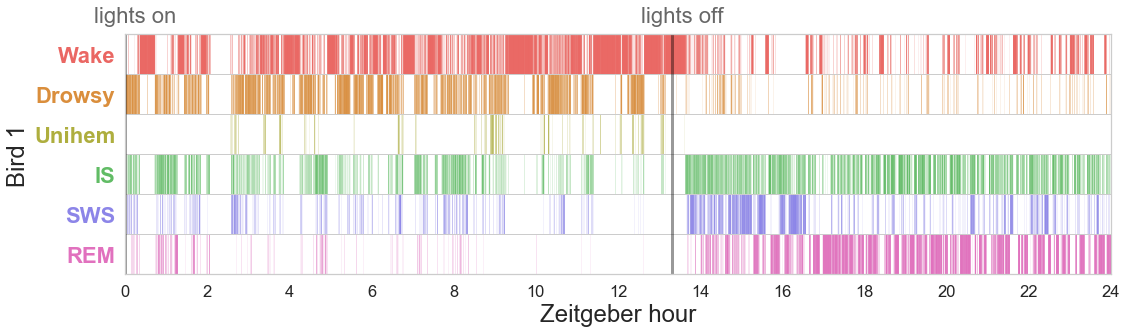

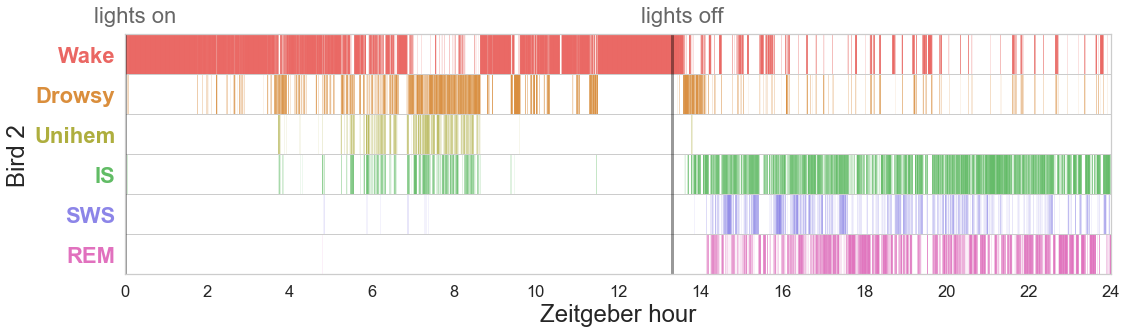

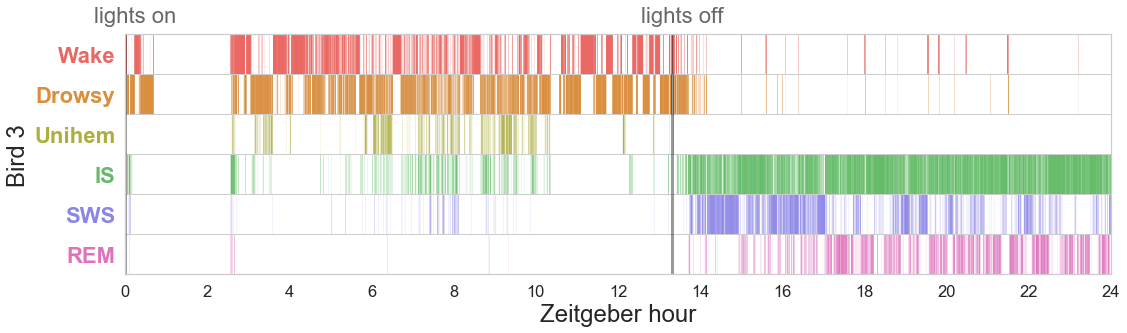

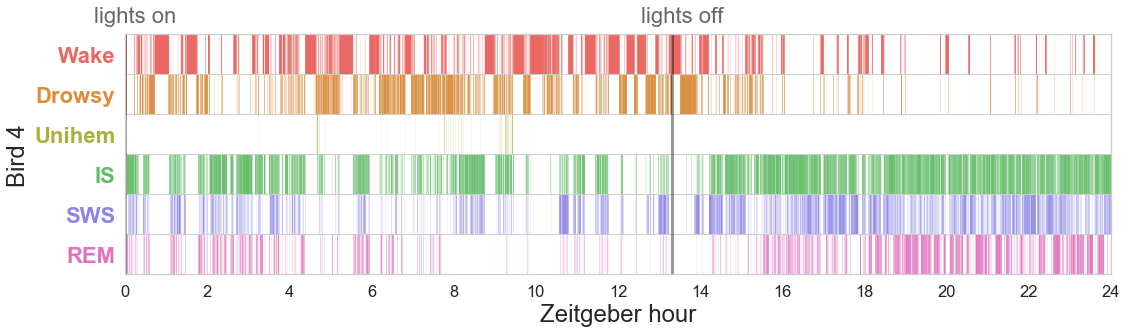

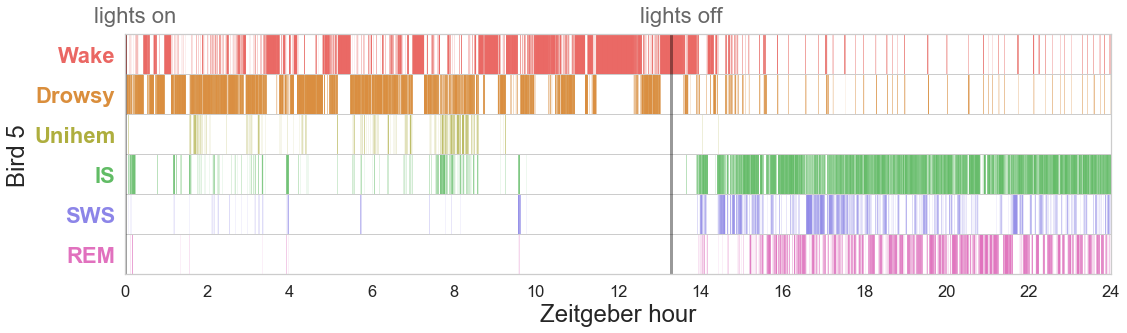

In [12]:
for b in range(nBirds):

    plt.figure(figsize=(16,5))

    plot_lightsonoff = True
    full_stagelabels = True
    plot_xlabels = True

    axis_color = [.8,.8,.8]
    with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline    
        PlotFig(b, plot_xlabels=plot_xlabels,
                plot_lightsonoff=plot_lightsonoff, full_stagelabels=full_stagelabels,
                xlim_min=0)

    if savePlots:
        plt.savefig(saveAsPath + 'FigS1_hypnogram_Bird' + str(b+1) + '_24hr.tiff', dpi=300)

# Individual 24-hr values

In [13]:
scores = AllScores['Bird 2']

In [14]:
### TST calc from video

TST_ep = len(scores[(scores['Video Label']=='s')|(scores['Video Label']=='l')|(scores['Video Label']=='r')])

TST_ep/len(scores)

0.38773236788971666

In [15]:
### TST calc from PSG
TST_ep = len(scores[(scores['Label']=='s')|(scores['Label']=='i')|(scores['Label']=='r')|(scores['Label']=='l')|(scores['Label']=='g')])

TST_ep/len(scores)

0.4022836454779642

# Drowsiness/sleep: video vs PSG scoring

In [16]:
all_sleep_to_drowsy = []
all_drowsy_to_sleep = []

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    scores = AllScores[b_name]
    sleep_to_drowsy = len(scores[(scores['Video Label']=='s') & (scores['Label']=='d')])
    drowsy_to_sleep = len(scores[(scores['Video Label']=='d') & ((scores['Label']=='i')|
                                                             (scores['Label']=='s')|
                                                             (scores['Label']=='r')|
                                                             (scores['Label']=='l')|
                                                             (scores['Label']=='g'))])
    
    print(b_name, sleep_to_drowsy, drowsy_to_sleep)
    eps_videoSleep = len(scores[scores['Video Label']=='s'])
    eps_videoDrowsy = len(scores[scores['Video Label']=='s'])
    
    # Save as % of orig. epochs
    all_sleep_to_drowsy.append(sleep_to_drowsy/eps_videoSleep)
    all_drowsy_to_sleep.append(drowsy_to_sleep/eps_videoDrowsy)

Bird 1 366 180
Bird 2 335 0
Bird 3 398 0
Bird 4 324 0
Bird 5 219 2


## Drowsy epochs reclassified as sleep

In [17]:
np.mean(all_drowsy_to_sleep)

0.0028834143274159762

In [18]:
np.std(all_drowsy_to_sleep)

0.005679515814683266

## Sleep epochs reclassified as drowsy

In [19]:
np.mean(all_sleep_to_drowsy)

0.026374199781395286

In [20]:
np.std(all_sleep_to_drowsy)

0.005115856361787356

# TST: video vs PSG scoring

In [21]:
TST_video = []
TST_psg   = []

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    scores = AllScores[b_name]

    ### TST calc from video

    TST_ep = len(scores[(scores['Video Label']=='s')|(scores['Video Label']=='l')|(scores['Video Label']=='r')])

    TST_video.append(TST_ep/len(scores))

    ### TST calc from PSG
    TST_ep = len(scores[(scores['Label']=='s')|(scores['Label']=='i')|(scores['Label']=='r')|(scores['Label']=='l')|(scores['Label']=='g')])

    TST_psg.append(TST_ep/len(scores))

In [22]:
TST_video

[0.4620486628360644,
 0.38773236788971666,
 0.545910724985021,
 0.5325060131767002,
 0.4261163593265242]

In [23]:
TST_psg

[0.46477974037029157,
 0.4022836454779642,
 0.5239289994008388,
 0.5579879387876041,
 0.4185868163279534]

In [24]:
tmp_TST = TST_video
print('Video scores')

print('TST mean:', round(np.mean(tmp_TST), 4))
print('SD:\t', round(np.std(tmp_TST), 4))
print('SEM:\t', round(np.std(tmp_TST)/np.sqrt(len(tmp_TST)), 4))

Video scores
TST mean: 0.4709
SD:	 0.0607
SEM:	 0.0271


In [25]:
tmp_TST = TST_psg
print('PSG scores')

print('TST mean:', round(np.mean(tmp_TST), 4))
print('SD:\t', round(np.std(tmp_TST), 4))
print('SEM:\t', round(np.std(tmp_TST)/np.sqrt(len(tmp_TST)), 4))

PSG scores
TST mean: 0.4735
SD:	 0.0597
SEM:	 0.0267


## change in TST

In [26]:
np.array(TST_psg) - np.array(TST_video)

array([ 0.00273108,  0.01455128, -0.02198173,  0.02548193, -0.00752954])

In [27]:
tmp_TST = np.abs(np.array(TST_psg) - np.array(TST_video))
print('Average absolute change:')

print('TST mean:', round(np.mean(tmp_TST), 4))
print('SD:\t', round(np.std(tmp_TST), 4))
print('SEM:\t', round(np.std(tmp_TST)/np.sqrt(len(tmp_TST)), 4))

Average absolute change:
TST mean: 0.0145
SD:	 0.0085
SEM:	 0.0038
